# Testes e Treinamento

## Prequential Evaluation

AUC: 0.8096822414863241


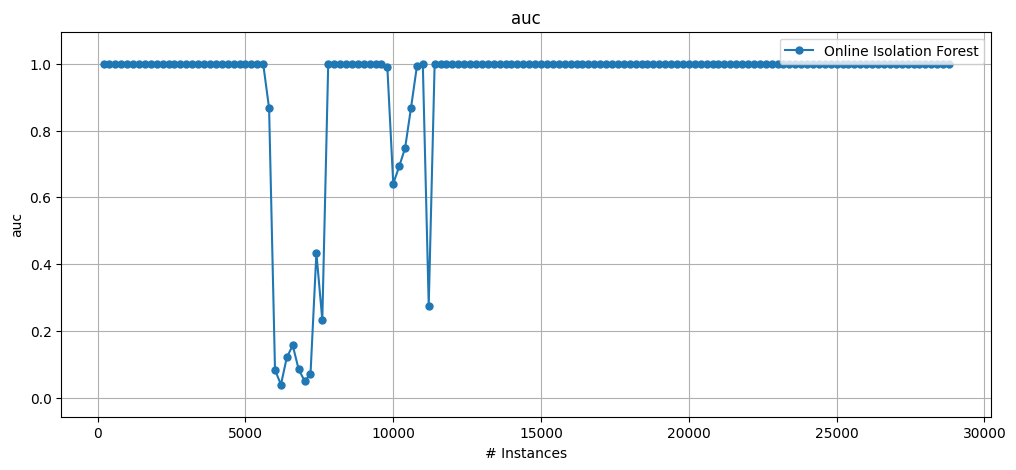

In [5]:
from capymoa.anomaly import OnlineIsolationForest
from capymoa.evaluation.visualization import plot_windowed_results
from capymoa.evaluation import prequential_evaluation_anomaly


oif = OnlineIsolationForest(schema=stream.get_schema())

results_oif = prequential_evaluation_anomaly(
    stream=stream, learner=oif, window_size=200
)

print(f"AUC: {results_oif.auc()}")
# display(results_oif.windowed.metrics_per_window())
plot_windowed_results(results_oif, metric="auc", save_only=False)

## Treinamento e Avaliação

In [61]:
import matplotlib.pyplot as plt
import numpy as np
from capymoa.anomaly import OnlineIsolationForest
from capymoa.evaluation import AnomalyDetectionEvaluator

def acumulative(WARMUP, stream, window_size=200):
    schema = stream.get_schema()
    learner = OnlineIsolationForest(schema=schema) 
    evaluator = AnomalyDetectionEvaluator(schema)

    history = {
        'instances': [],
        'auc': [],
        'acc': []
    }
    
    attack_regions = []
    in_attack = False
    start_attack = 0

    count = 0
    stream.restart()
    while stream.has_more_instances():
        instance = stream.next_instance()
        is_attack = (instance.y_index == 1) 
        
        if is_attack and not in_attack:
            in_attack = True
            start_attack = count
        elif not is_attack and in_attack:
            in_attack = False
            attack_regions.append((start_attack, count))
        
        if count < WARMUP:
            learner.train(instance)
        else:
            score = learner.score_instance(instance)
            evaluator.update(instance.y_index, score)
            learner.train(instance)

            if count % window_size == 0:
                metrics_dict = evaluator.metrics_dict()
                auc = evaluator.auc()            
                accuracy_score = metrics_dict.get('Accuracy')
                
                history['instances'].append(count)
                history['auc'].append(auc)
                history['acc'].append(accuracy_score)
            
        count += 1
        
    if in_attack:
        attack_regions.append((start_attack, count))

    plt.figure(figsize=(14, 6))
    plt.plot(history['instances'], history['acc'], color='#2ca02c', linewidth=2.0, label='Acurácia')
    plt.plot(history['instances'], history['auc'], color='#1f77b4', linewidth=2.0, label='AUC')
    
    for start, end in attack_regions:
        plt.axvspan(start, end, facecolor='red', alpha=0.15, edgecolor='none', label='Região de Ataque')

    plt.title("Desempenho")
    plt.xlabel("Instâncias")
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys())
    
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.show()

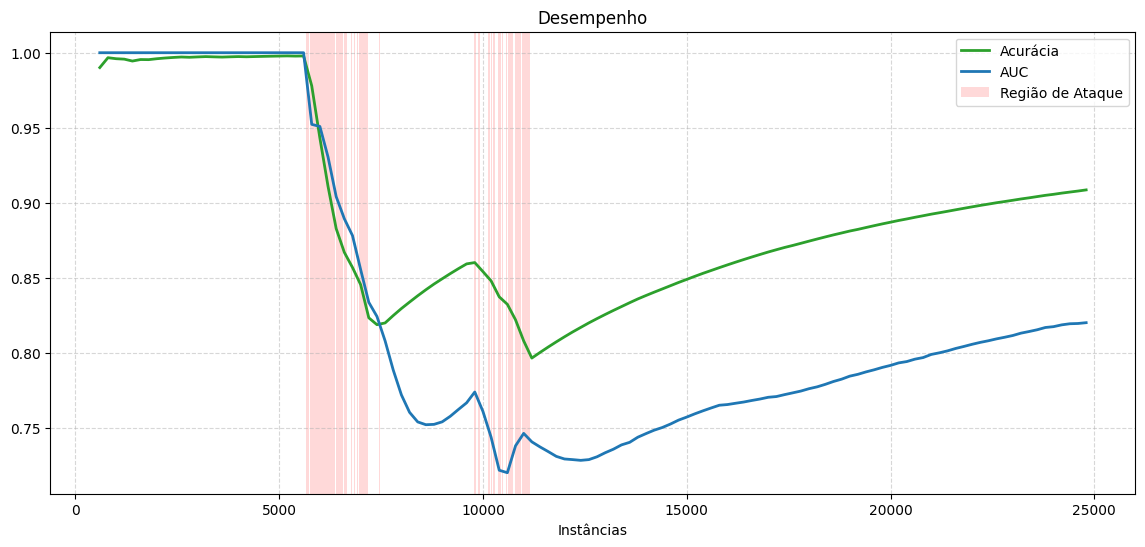

In [62]:
acumulative(WARMUP=500, stream=stream, window_size=200)

## Experimento

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from capymoa.evaluation import AnomalyDetectionEvaluator
from capymoa.drift.detectors import ADWIN

def plot(results, attack_regions, title):
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10), sharex=True)
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c'] 
    
    for i, (name, data) in enumerate(results.items()):
        color = colors[i % len(colors)]
        for d_idx, drift_pos in enumerate(data['drifts']):
            ax1.axvline(x=drift_pos, color='black', alpha=0.8, linestyle='-', linewidth=1, zorder=1)
            ax2.axvline(x=drift_pos, color='black', alpha=0.8, linestyle='-', linewidth=1, zorder=1)
            
            if i == 0 and d_idx == 0:
                ax1.plot([], [], color='black', label='Drift Detectado')
                ax2.plot([], [], color='black', label='Drift Detectado')

        ax1.plot(data['instances'], data['auc'], label=f'AUC {name}', color=color, linewidth=2.5, zorder=3)
        ax2.plot(data['instances'], data['acc'], label=f'Acc {name}', color=color, linestyle='--', linewidth=2.5, zorder=3)

    for ax in [ax1, ax2]:
        added_attack_label = False
        for start, end in attack_regions:
            ax.axvspan(start, end, facecolor="#F7C5CD", alpha=0.4, zorder=2,
                       label='Região de Ataque' if not added_attack_label else "")
            added_attack_label = True
            
        ax.legend(loc='best', fontsize=10, frameon=True, framealpha=0.9)
        ax.grid(True, alpha=0.3, linestyle=':', zorder=0)
        ax.tick_params(axis='both', which='major', labelsize=12)
    
    ax1.set_ylabel("AUC", fontsize=14)
    ax2.set_ylabel("Accuracy", fontsize=14)
    ax2.set_xlabel("Instâncias", fontsize=14)
    ax1.set_ylim(0.0, 1.05) 
    ax2.set_ylim(0.0, 1.05) 
    plt.suptitle(title, fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()

def plot_score(results, attack_regions, title):
    num_models = len(results)
    fig, axes = plt.subplots(num_models, 1, figsize=(15, 5 * num_models), sharex=True)
    if num_models == 1: axes = [axes]

    for i, (name, data) in enumerate(results.items()):
        ax = axes[i]
        scores = np.array(data['scores'])
        instances = np.arange(len(scores))
        window_size = 30
        moving_avg = np.array([np.mean(scores[max(0, j-window_size):j]) if j > 0 else scores[0] for j in range(len(scores))])
        
        ax.scatter(instances, scores, color="#1f77b4", s=15, alpha=0.4, edgecolors='none', label='Amostra (Score)', zorder=1)
        ax.plot(instances, moving_avg, color="#0400F7", alpha=0.6, linewidth=1.5, label='Média Móvel', zorder=2)

        added_attack_label = False
        for start, end in attack_regions:
            ax.axvspan(start, end, facecolor="#F7C5CD", alpha=0.3, zorder=0,
                       label='Região de Ataque' if not added_attack_label else "")
            added_attack_label = True

        ax.set_title(f"Análise de Scores - {name}", fontsize=12, fontweight='bold')
        ax.set_ylabel("Score de Anomalia", fontsize=14)
        ax.legend(loc='upper right', fontsize=10)
        ax.grid(True, alpha=0.15, linestyle=':')
        ax.set_ylim(0.0, 1.1)

    axes[-1].set_xlabel("Instâncias", fontsize=14)
    plt.suptitle(title, fontsize=16, fontweight='bold')
    plt.tight_layout(rect=[0, 0.03, 1, 0.97])
    plt.show()

def adaptation(window_scores, beta=0.3, anomaly_threshold=0.6):
    if not window_scores: return False, 0.0
    anomalies = [s for s in window_scores if s > anomaly_threshold]
    anomaly_rate = len(anomalies) / len(window_scores)
    triggered = anomaly_rate > beta
    return triggered, anomaly_rate

def pipeline_1(stream, algorithms, warmup_windows, window_size, title, anomaly_threshold=0.6, beta=0.3, logging=False):
    results = {} 
    attack_regions = []
    warmup_instances = warmup_windows * window_size

    for alg in algorithms:
        stream.restart()
        schema = stream.get_schema()
        learner = alg['class'](schema=schema, **alg.get('params', {}))
        evaluator = AnomalyDetectionEvaluator(schema)
        drift_detector = ADWIN()
        
        history = {'instances': [], 'auc': [], 'acc': [], 'scores': [], 'drifts': []}
        window_instances = []
        window_scores = []
        count = 0
        in_attack, start_attack = False, 0

        while stream.has_more_instances():
            instance = stream.next_instance()
            
            if alg == algorithms[0]:
                is_attack = (instance.y_index == 1)
                if is_attack and not in_attack:
                    in_attack, start_attack = True, count
                elif not is_attack and in_attack:
                    in_attack = False
                    attack_regions.append((start_attack, count))

            score = learner.score_instance(instance) 
            history['scores'].append(score)
            window_scores.append(score)
            window_instances.append(instance)

            drift_detector.add_element(score)
            if drift_detector.detected_change():
                history['drifts'].append(count)

            if score < anomaly_threshold:
                try: learner.train(instance)
                except ValueError: pass

            if count > 0 and count % window_size == 0:
                triggered, rate = adaptation(window_scores, beta=beta, anomaly_threshold=anomaly_threshold)
                
                if count <= warmup_instances:
                    for inst in window_instances:
                        try: learner.train(inst)
                        except ValueError: pass
                    status = "TREINO REALIZADO (WARMUP)"
                elif not triggered:
                    for inst in window_instances:
                        try: learner.train(inst)
                        except ValueError: pass
                    status = "TREINO REALIZADO"
                else:
                    history['drifts'].append(count)
                    status = "TREINO BLOQUEADO (JANELA ANÔMALA)"
                
                if logging:
                    print(f"[{alg['name']}] Instância: {count} | {status} | Taxa de Anomalia: {rate:.2%}")
                
                window_scores = []
                window_instances = []
            
            evaluator.update(instance.y_index, score)
            if count % window_size == 0:
                metrics = evaluator.metrics_dict()
                history['instances'].append(count)
                history['auc'].append(evaluator.auc())
                history['acc'].append(metrics.get('Accuracy', 0))
                    
            count += 1
            
        results[alg['name']] = history

    plot(results, attack_regions, title)
    plot_score(results, attack_regions, title)

def pipeline_2(stream, algorithms, window_size, title):
    results = {} 
    attack_regions = []

    for alg in algorithms:
        stream.restart()
        schema = stream.get_schema()
        learner = alg['class'](schema=schema, **alg.get('params', {}))
        evaluator = AnomalyDetectionEvaluator(schema)
        drift_detector = ADWIN()
        
        history = {'instances': [], 'auc': [], 'acc': [], 'scores': [], 'drifts': []}
        count = 0
        in_attack, start_attack = False, 0

        while stream.has_more_instances():
            instance = stream.next_instance()
            
            if alg == algorithms[0]:
                is_attack = (instance.y_index == 1)
                if is_attack and not in_attack:
                    in_attack, start_attack = True, count
                elif not is_attack and in_attack:
                    in_attack = False
                    attack_regions.append((start_attack, count))

            # Predição do Score
            score = learner.score_instance(instance) 
            history['scores'].append(score)

            # Detecção de Drift 
            drift_detector.add_element(score)
            if drift_detector.detected_change():
                history['drifts'].append(count)

            # Treino Integral
            try:
                learner.train(instance)
            except ValueError:
                pass

            # Avaliação Constante
            evaluator.update(instance.y_index, score)
            if count % window_size == 0:
                metrics = evaluator.metrics_dict()
                history['instances'].append(count)
                history['auc'].append(evaluator.auc())
                history['acc'].append(metrics.get('Accuracy', 0))
                    
            count += 1
            
        results[alg['name']] = history

    plot(results, attack_regions, title)
    plot_score(results, attack_regions, title)

def ExecuteExperiments(stream, n_pipeline, algorithms, warmup_windows=5, window_size=200, 
                       anomaly_threshold=0.4, beta=0.3, title="Desempenho dos Algoritmos", logging=False):
    if n_pipeline == 1:
        pipeline_1(stream, algorithms, warmup_windows, window_size, 
                   anomaly_threshold=anomaly_threshold, beta=beta, title=title, logging=logging)
    elif n_pipeline == 2:
        pipeline_2(stream, algorithms, window_size, title=title)

# Execução e Resultados

## Stream

In [19]:
from py.streams import newStream
import pandas as pd

inicio = 0
fim = 20000
quantidade = fim - inicio
MAX_INSTANCES = quantidade

df = pd.read_csv(
    'datasets/CICDDoS2019/data/Exp_janela/SNMP_DNS_1s_0112.csv', 
    skiprows=range(1, inicio), 
    nrows=quantidade
)

# df = pd.read_csv(
#     'datasets/MURILO/syn.csv', 
#     skiprows=range(1, inicio), 
#     nrows=quantidade
# )


# df = pd.read_csv(
#     'datasets/CICDDoS2019/01-12/janelado/BENIGN_1s.csv', 
#     skiprows=range(1, inicio), 
#     nrows=quantidade
# )

stream, target_names, feature_names = newStream(
    df=df, 
    target_label_col='Label', 
    binary_label=True, 
    normalize_method="MinMaxScaler", 
    threshold_var=0.75,
    threshold_corr=0.95,
    top_n_features=15,
    stream=True
)


Limpeza: Removendo espaços, identificadores (Flow ID, Timestamp, Umma,ed: 0) e colunas vazias...
Pré-processamento: Convertendo infinitos e preenchendo valores nulos...
Target: Processando coluna 'Label' como Binário (0=Normal, 1=Attack)...
Seleção de Features: Iniciando pipeline de redução de dimensionalidade...

--- Iniciando Processo de Seleção de Features (Total: 83) ---
Variância: 16 features removidas. Restantes: 67
Correlação (>0.95): 34 features redundantes removidas. Restantes: 33
Random Forest: Top 15 selecionadas.
Features Finais (15) - ['Flow Bytes/s', 'Total Length of Fwd Packets', 'Destination Port_Entropy', 'Total Fwd Packets', 'Init_Win_bytes_backward', 'Fwd Header Length', 'Init_Win_bytes_forward', 'min_seg_size_forward', 'Flow IAT Min', 'Source Port_Entropy', 'Bwd Packets/s', 'Flow IAT Mean', 'Flow IAT Std', 'Fwd IAT Mean', 'Packet Length Variance']
--- Fim do Processo de Seleção de Features ---

Normalização: MinMaxScaler
Finalização: Criando objeto NumpyStream para 

## Resultados

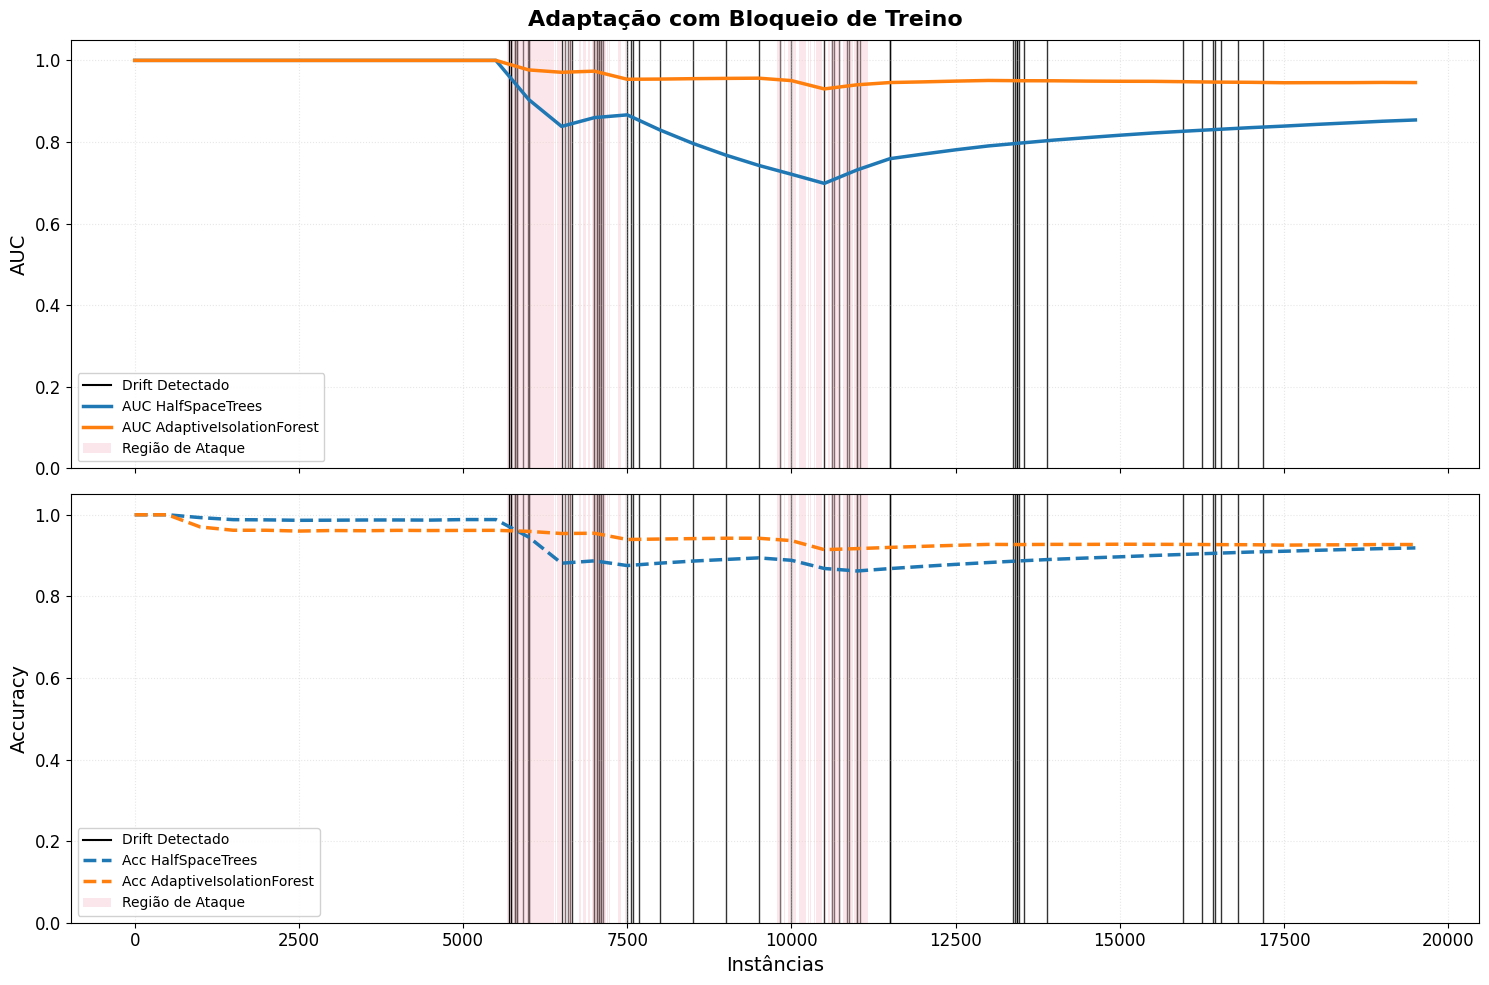

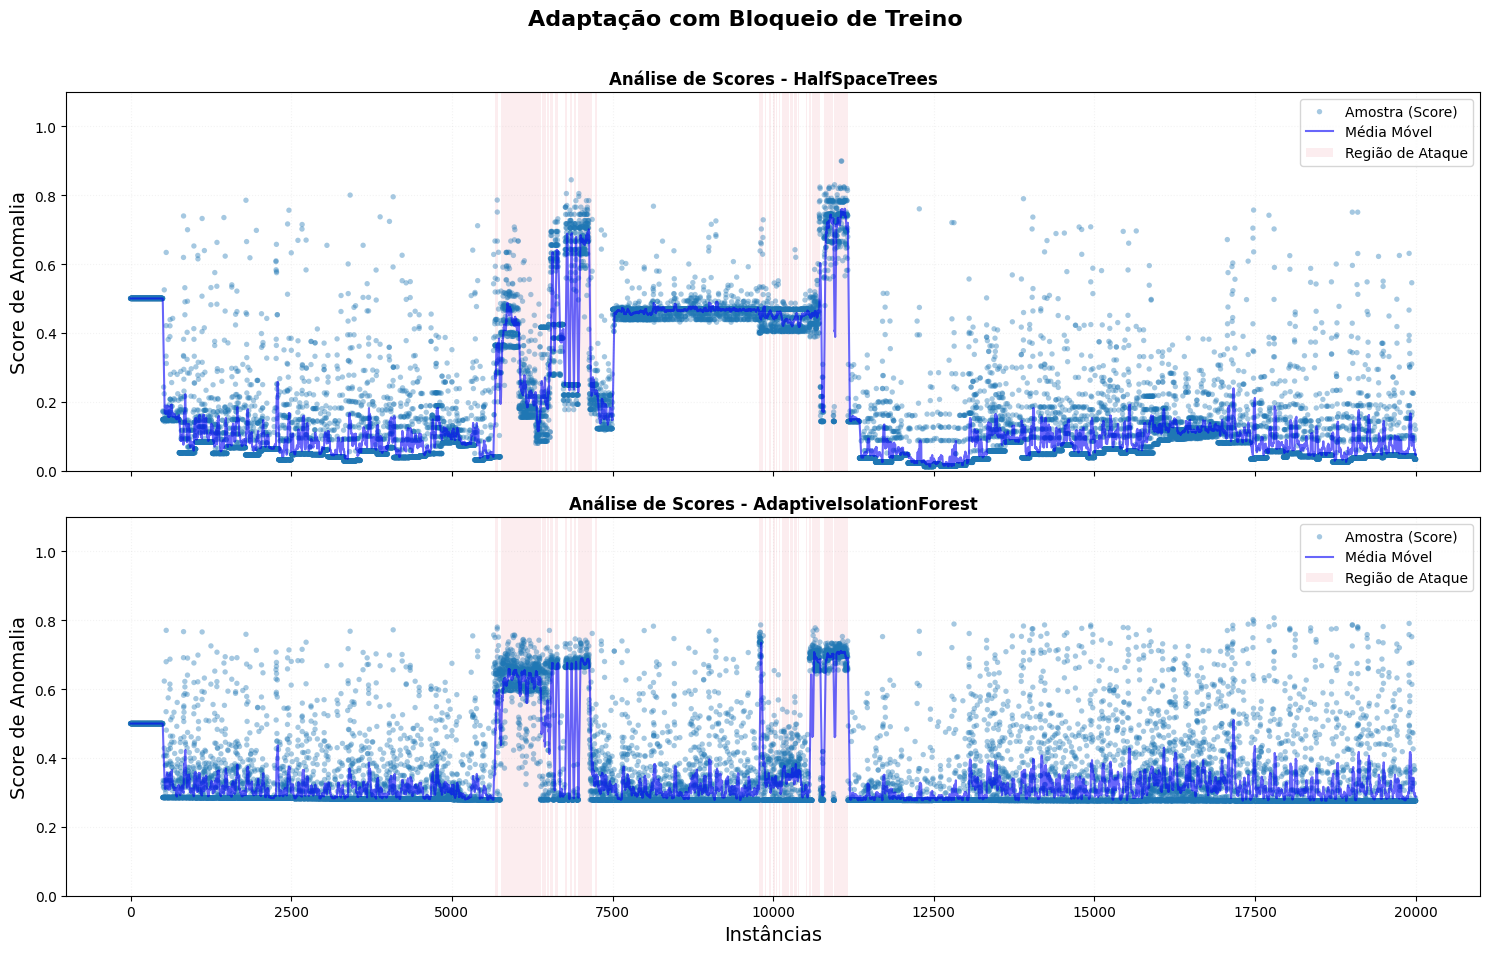

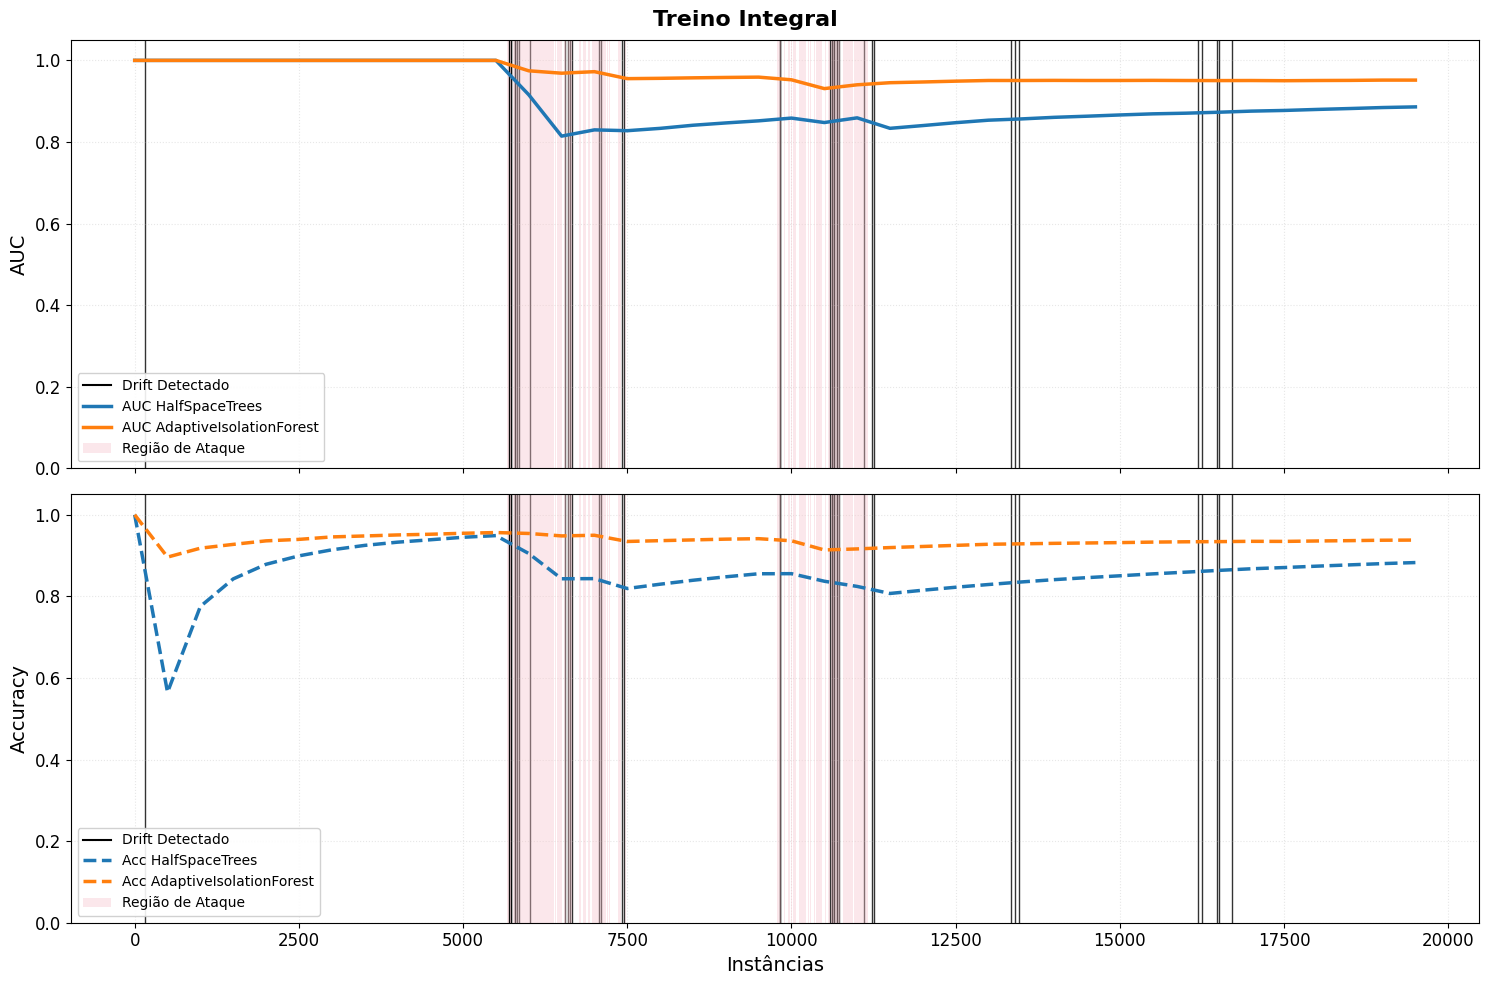

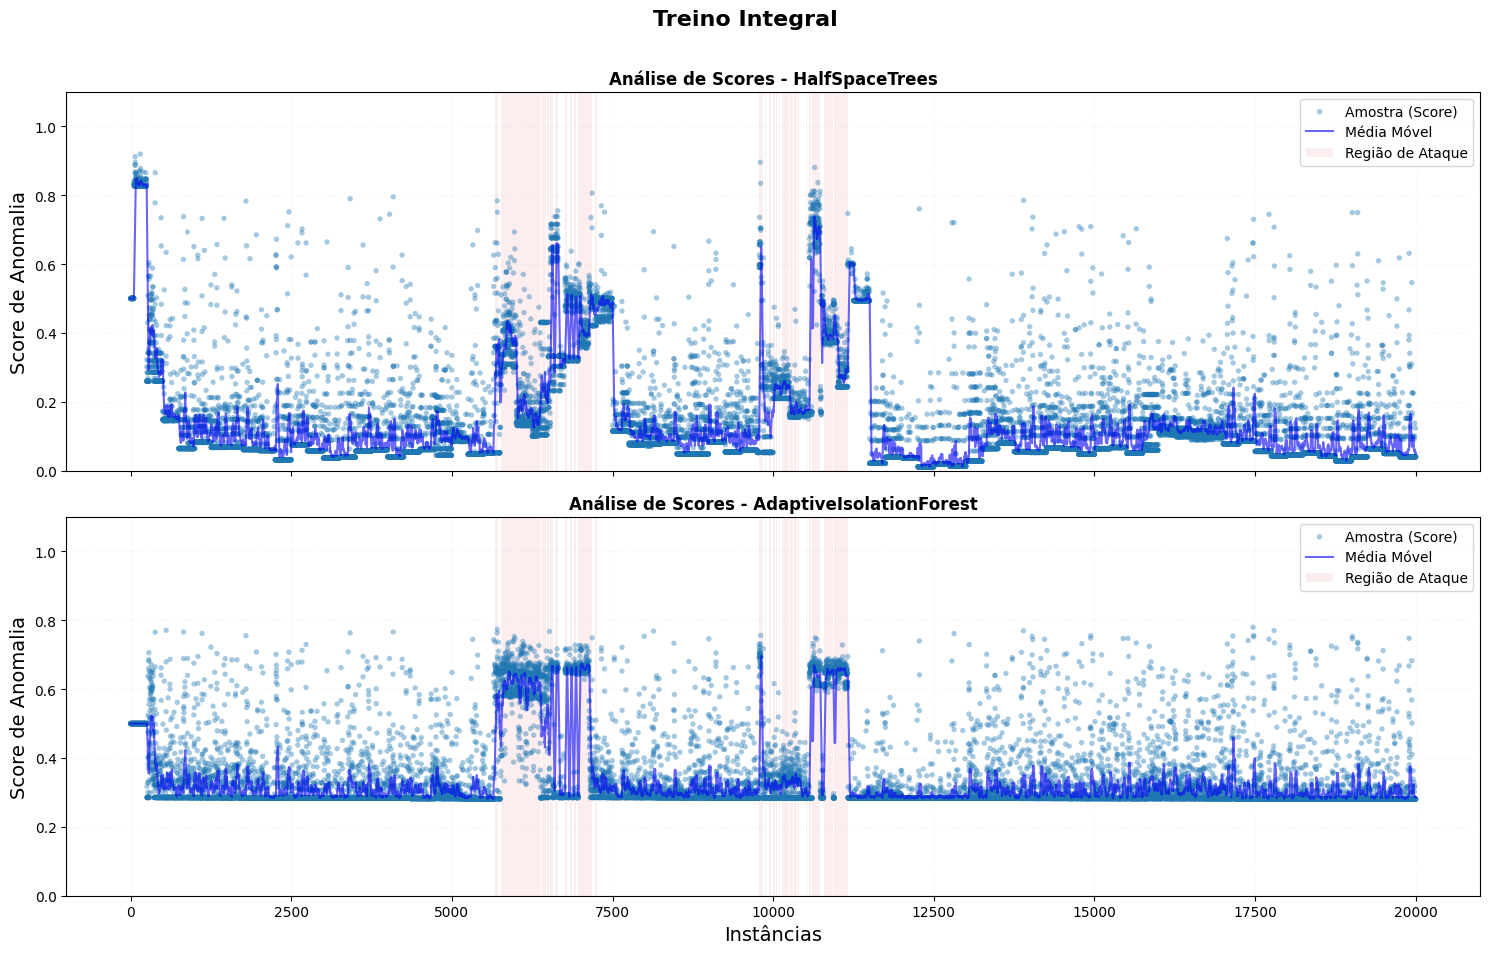

In [21]:
from capymoa.anomaly import HalfSpaceTrees
from capymoa.anomaly import OnlineIsolationForest
from capymoa.anomaly import Autoencoder
from capymoa.anomaly import StreamRHF
from capymoa.anomaly import StreamingIsolationForest
from capymoa.anomaly import RobustRandomCutForest
from capymoa.anomaly import AdaptiveIsolationForest

algoritmos = [
    {'name': 'HalfSpaceTrees', 'class': HalfSpaceTrees, 'params': {}},
    # {'name': 'OnlineIsolationForest', 'class': OnlineIsolationForest, 'params': {}},
    # {'name': 'Autoencoder', 'class': Autoencoder, 'params': {}},
    # {'name': 'StreamRHF', 'class': StreamRHF, 'params': {}}, # DEMORA MUITO
    # {'name': 'StreamingIsolationForest', 'class': StreamingIsolationForest, 'params': {}}, # DEMORA MUITO
    # {'name': 'RobustRandomCutForest', 'class': RobustRandomCutForest, 'params': {}}, # DEMORA MUITO
    {'name': 'AdaptiveIsolationForest', 'class': AdaptiveIsolationForest, 'params': {}},
]

ExecuteExperiments(stream, n_pipeline=1, algorithms=algoritmos, warmup_windows=3, window_size=500, 
        anomaly_threshold=0.4, beta=0.3, title="Adaptação com Bloqueio de Treino", logging=False)

ExecuteExperiments(stream, n_pipeline=2, algorithms=algoritmos, 
                   window_size=500, title="Treino Integral")

# Aprendizagem Contínua

In [ ]:
import torch
from typing import Tuple
from torch import Tensor

class ReservoirSampler:
    def __init__(self, item_count: int, feature_count: int):
        self.item_count = item_count
        self.feature_count = feature_count
        self.reservoir_x = torch.zeros((item_count, feature_count))
        self.reservoir_y = torch.zeros((item_count,), dtype=torch.long)
        self.count = 0

    def update(self, x: Tensor, y: Tensor) -> None:
        batch_size = x.shape[0]
        assert x.shape == (
            batch_size,
            self.feature_count,
        )
        assert y.shape == (batch_size,)

        for i in range(batch_size):
            if self.count < self.item_count:
                # Fill the reservoir
                self.reservoir_x[self.count] = x[i]
                self.reservoir_y[self.count] = y[i]
            else:
                # Reservoir sampling
                index = torch.randint(0, self.count + 1, (1,))
                if index < self.item_count:
                    self.reservoir_x[index] = x[i]
                    self.reservoir_y[index] = y[i]
            self.count += 1

    def sample_n(self, n: int) -> Tuple[Tensor, Tensor]:
        indices = torch.randint(0, min(self.count, self.item_count), (n,))
        return self.reservoir_x[indices], self.reservoir_y[indices]

In [ ]:
from matplotlib import pyplot as plt

x = torch.arange(0, 1_000).reshape(-1, 1).float()
y = torch.zeros(1_000, dtype=torch.long)
sampler = ReservoirSampler(500, 1)
sampler.update(x, y)
x = sampler.sample_n(200)
plt.hist(x[0].numpy(), bins=20)
plt.show()

In [ ]:
from capymoa.base import BatchClassifier
from capymoa.stream import Schema
from torch.nn.functional import cross_entropy
import numpy as np
from torch import nn


class ExperienceReplay(BatchClassifier):
    def __init__(
        self,
        schema: Schema,
        model: nn.Module,
        reservoir_size: int,
        learning_rate: float,
        device: str = "cpu",
    ):
        super().__init__(schema=schema)
        self.reservoir = ReservoirSampler(reservoir_size, schema.get_num_attributes())
        self.optimiser = torch.optim.Adam(model.parameters(), lr=learning_rate)
        self.device = torch.device(device)
        self.model = model.to(self.device)

    def batch_train(self, x: Tensor, y: Tensor):
        batch_size = x.shape[0]

        self.reservoir.update(x, y)

        replay_x, replay_y = self.reservoir.sample_n(batch_size)
        train_x = torch.cat((x, replay_x), dim=0).to(self.device)
        train_y = torch.cat((y, replay_y), dim=0).to(self.device)

        self.optimiser.zero_grad()
        y_hat = self.model(train_x)
        loss = cross_entropy(y_hat, train_y)
        loss.backward()
        self.optimiser.step()

    @torch.no_grad()
    def batch_predict_proba(self, x: Tensor) -> Tensor:
        y_hat: Tensor = self.model.forward(x)
        return y_hat.softmax(dim=1)

    def __str__(self) -> str:
        return "ExperienceReplay"

In [ ]:
class SimpleMLP(nn.Module):
    def __init__(self, schema: Schema, hidden_size: int):
        super().__init__()
        num_classes = schema.get_num_classes()

        self.fc1 = nn.Linear(schema.get_num_attributes(), hidden_size)
        self.fc2 = nn.Linear(hidden_size, num_classes, bias=False)
        self.fc2 = nn.utils.parametrizations.weight_norm(self.fc2, name="weight")
        weight_g = self.fc2.parametrizations.weight.original0
        # Set the magnitude to the unit vector
        weight_g.requires_grad_(False).fill_(1.0 / (num_classes**0.5))

    def forward(self, x: Tensor) -> Tensor:
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [ ]:
from capymoa.ocl.evaluation import ocl_train_eval_loop
from capymoa.ocl.datasets import SplitMNIST

stream = SplitMNIST()
mlp = SimpleMLP(stream.schema, 64)
learner = ExperienceReplay(
    stream.schema,
    mlp,
    reservoir_size=200,
    learning_rate=0.01,
    device="cpu",
)
r = ocl_train_eval_loop(
    learner,
    stream.train_loaders(64),
    stream.test_loaders(64),
    progress_bar=True,
    continual_evaluations=4,
)
print(f"Forward Transfer  {r.forward_transfer:.2f}")
print(f"Backward Transfer {r.backward_transfer:.2f}")
print(f"Accuracy          {r.accuracy_final:.2f}")
print(f"Prequential Acc.  {r.ttt.cumulative.accuracy() / 100:.2f}")

In [ ]:
from matplotlib import pyplot as plt

fig, ax = plt.subplots(figsize=(8, 4))

cmap = plt.get_cmap("tab10")
for t in range(5):
    ax.scatter(r.task_index, r.accuracy_matrix[:, t], color=cmap(t), label=f"Task {t}")
    ax.plot(r.anytime_task_index, r.anytime_accuracy_matrix[:, t], color=cmap(t))

ax.set_xlabel("Task")
ax.set_xticks(range(6))
ax.set_ylabel("Accuracy")
ax.set_title("SplitMNIST Per-Task Accuracy Over Tasks")
ax.legend(frameon=False)
pass

In [ ]:
def hline(ax, y, label, color):
    ax.hlines(y, 0, 5, linestyles="--", label=label, color=color)


fig, ax = plt.subplots(figsize=(8.2, 4))
# Plot the accuracy on all tasks over the course of tasks
ax.scatter(r.task_index, r.accuracy_all, label="Acc. (all)")
ax.plot(r.anytime_task_index, r.anytime_accuracy_all, label="Anytime Acc. (all)")
hline(ax, r.anytime_accuracy_all_avg, "Avg. Anytime Acc. (all)", cmap(0))

# Plot the accuracy on previously seen tasks over the course of tasks
ax.scatter(r.task_index, r.accuracy_seen, label="Acc. (seen)")
ax.plot(r.anytime_task_index, r.anytime_accuracy_seen, label="Anytime Acc. (seen)")
hline(ax, r.anytime_accuracy_seen_avg, "Avg. Anytime Acc. (seen)", cmap(1))

# Windowed test-then-train accuracy
ax.plot(
    r.ttt_windowed_task_index,
    np.array(r.ttt.windowed.accuracy()) / 100,  # percentage to proportion
    label="Online Win. Acc.",
)
# Cumulative test-then-train accuracy
hline(ax, r.ttt.cumulative.accuracy() / 100, "Online Avg. Acc.", cmap(2))

ax.legend(ncol=3, frameon=False)
ax.set_xlabel("Task")
ax.set_xticks(range(6))
ax.set_ylabel("Accuracy")
ax.set_title("SplitMNIST Accuracy Over Tasks")
ax.set_ylim(-0.1, 1.05)
pass

In [ ]:
from capymoa.evaluation.visualization import plot_windowed_results

plot_windowed_results(r.ttt, metric="accuracy")